# Mosig M2 Computer Vision Practicals
## Ana GRANIZO & Piotr HANDKOWSKI (Group 4)

In [268]:
# import the necessar libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimggit 
import math
import os
import random
from glob import glob
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import keras
import csv
import time
import imutils


# WEEK 1

## BoundingBox Class & AnnotatedImage Class
BoundingBox Class stores the information about the bounding box that is used to draw ellipse/square and to extract faces from the images. The class provides methods that return information on the bounding boxes as well as a method that calculates the Intersection Over Union between 2 boxes.
AnnotatedImage class stores the information of each picture : location, number and location of faces. It has 2 methods. One to add a location of a new face. The other method displays the image wih ellipses drawn on it.

In [4]:
class BoundingBox:
    def __init__(self, centX, centY, axisX, axisY, angle=0):
        self.centerX = centX
        self.centerY = centY
        self.axisX = axisX
        self.axisY = axisY
        self.angle = angle

    # returns coordinates used to draw ellipse
    def getEllipseCoord(self):
        return (self.centerX, self.centerY), (self.axisY, self.axisX), self.angle

    # returns coordinates used to draw rectancle or extract a rectancle from an image
    def getRectangleCoord(self):
        return (self.centerX - self.axisX, self.centerY - self.axisY), (self.centerX + self.axisX, self.centerY + self.axisY)

    def calculateIOU(self, top, bottom, left, right):
        # as we are looking for a background of the same size as the face you calculate the area only once
        A1 = (self.axisX * 2) * (self.axisY * 2)
        A2 = (right - left) * (bottom - top)

        l_i = max(self.centerX - self.axisX, left)
        t_i = max(self.centerY - self.axisY, top)
        r_i = min(self.centerX + self.axisX, right)
        b_i = min(self.centerY + self.axisY, bottom)

        A_i = max((r_i - l_i) + 1, 0) * max((b_i - t_i) + 1, 0)

        IOU = A_i / (A1 + A2 - A_i)

        return IOU


   # calculates the IOU for a given level in a pyramid
    def calculatePyramidIOU(self, top, bottom, left, right, level):
            
        # adjusting the window size for the pyramid level
        axX = int(self.axisX / pow(2, level))
        axY = int(self.axisY / pow(2, level))
        cenX = int(self.centerX / pow(2, level))
        cenY = int(self.centerY / pow(2, level))

        A1 = (axX * 2) * (axY * 2)
        A2 = (right - left) * (bottom - top)

        l_i = max(cenX - axX, left)
        t_i = max(cenY - axY, top)
        r_i = min(cenX + axX, right)
        b_i = min(cenY + axY, bottom)

        A_i = max((r_i - l_i) + 1, 0) * max((b_i - t_i) + 1, 0)

        IOU = A_i / (A1 + A2 - A_i)

        return IOU
    

    def getWidth(self):
        return self.axisX * 2

    def getHeight(self):
        return self.axisY * 2
    
    def getStartX(self):
        return self.centerX - self.axisX

    def getStartY(self):
        return self.centerY - self.axisY

    def getEndX(self):
        return self.centerX + self.axisX

    def getEndY(self):
        return self.centerY + self.axisY


        
    


class AnnotatedImage:
    def __init__(self, path, face_number):
        self.path = path
        self.faces = face_number
        self.faceBoxes = []


    def addFace(self, bounding_box):
        self.faceBoxes.append(bounding_box)

    # by defauls prints ellipses, if we pass "rectangle" it will print rectangles as bounding box
    def displayAnnotatedImage(self, type="ellipse"):
        image = cv2.imread(self.path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for face in self.faceBoxes:

            color = (0, 0, 255) # blue colour for the bounding box
            thickness = 3   

            if type == "ellipse":
                center_coordinates, axesLength, angle = face.getEllipseCoord()
                startAngle = 0 
                endAngle = 360
                image = cv2.ellipse(image, center_coordinates, axesLength,
                                    angle, startAngle, endAngle, color, thickness)
            elif type == "rectangle":                        

                start, end = face.getRectangleCoord()
                image = cv2.rectangle(image, start, end, color, thickness)

            plt.imshow(image)

    # returns imported image
    def getRawImage(self):
        return cv2.imread(self.path)

    def getRawImageGray(self):
        return cv2.imread(self.path, 0)






## AnnotatedImage Extraction
We go through all the files containing informations about images (path, number of faces, locations of faces) and create AnnotatedImages which we store in the images array. 

### Note : the FDDB-folds and originalPics folders should be in the same directory as this file!

In [5]:
def getFDDBImages(folds=['01', '02', '03','04', '05', '06', '07', '08', '09', '10']):
    images = []
    
    for fold in folds:
        filepath = 'FDDB-folds/FDDB-fold-' + fold + '-ellipseList.txt'


        with open(filepath) as fp:

            imgPath = fp.readline()

            while imgPath:
                imagePath = 'originalPics/' + (imgPath).rstrip('\n') + '.jpg'
                numFaces = fp.readline()
                annotImage = AnnotatedImage(imagePath, int(numFaces))
                for x in range(int(numFaces)):

                    # we extract the information of the bounding boxes from a line of text
                    coordinates = fp.readline()
                    items = (coordinates).split(' ')
                    centerX = int(float(items[3]))
                    centerY = int(float(items[4]))
                    center_coordinates = (centerX, centerY)
                    majorAxis = int(float(items[0]))
                    minorAxis = int(float(items[1]))
                    axesLength = (majorAxis, minorAxis)
                    angle = int(math.degrees(float(items[2])))
                    face = BoundingBox(centerX, centerY, minorAxis, majorAxis, angle)
                    annotImage.addFace(face)


                images.append(annotImage)

                imgPath = fp.readline()
    return images


images = getFDDBImages()
    

We can now display the images with either ellipse of a rectangle

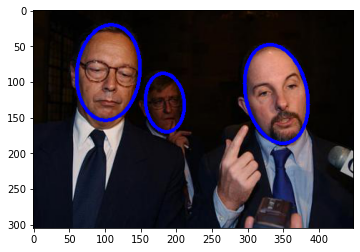

In [6]:
images[1].displayAnnotatedImage()

In [5]:
images[1].displayAnnotatedImage("rectangle")

# WEEK 2

In [73]:
#we will now extract all faces and backgrounds to train the model
def extracTrainingData():
    # indices to keep track of number of faces and backgrounds. used to name face and background images
    faceIndex = 0
    backgroundIndex = 0
    # we extract faces and backgrounds from 8 folds and keep them seperately, this will alow us 
    fileNumbers = ['01', '02', '03','04', '05', '06', '07', '08']
    for num in fileNumbers:
        # file path to the txt file will all information
        filepath = 'FDDB-folds/FDDB-fold-' + num + '-ellipseList.txt'
        # we create a folder for each fold. in the folder we also create 2 sub directories one for the faces and one 
        # for the backgrounds
        foldPath = "./TrainData/fold" + num
        faceFoldPath = "./TrainData/fold" + num + "/faces"
        backgrFoldPath = "./TrainData/fold" + num + "/background"

        try:
            os.mkdir(foldPath)
            os.mkdir(faceFoldPath)
            os.mkdir(backgrFoldPath)
        except OSError:
            print ("Creation of the directory failed")
        else:
            print ("Successfully created the directory")

        with open(filepath) as fp:

            # the first line is the name of the image
            imgPath = fp.readline()

            while imgPath:

                imagePath = 'originalPics/' + (imgPath).rstrip('\n') + '.jpg'
                numFaces = fp.readline()
                img = cv2.imread(imagePath)
                imgWidth = img.shape[1]
                imgHeight = img.shape[0]
                # we will keep all bounding boxes for each image in a list so that we can extract 1 background for each face
                currentImageFeceBoxes = []

                for x in range(int(numFaces)):

                    coordinates = fp.readline()
                    items = (coordinates).split(' ')
                    centerX = int(float(items[3]))
                    centerY = int(float(items[4]))
                    axisY = int(float(items[0]))
                    axisX = int(float(items[1]))

                    # the face is extracted on the basis of the bounding box from the text file
                    face = img[max(centerY - axisY, 0) : max(centerY + axisY, 0), max(centerX - axisX, 0) : max(centerX + axisX, 0), :]
                    # and saved in the face directory of the current fold
                    cv2.imwrite(faceFoldPath + "/" + str(faceIndex) + '.jpg', face)
                    if  num != '01':
                        cv2.imwrite("./TrainData/allTrain/face/" + str(faceIndex) + '.jpg', face)
                    faceIndex += 1

                    box = BoundingBox(centerX, centerY, axisX, axisY)
                    currentImageFeceBoxes.append(box)


                # for each face add a background image
                for box in currentImageFeceBoxes:
                    
                    foundBackground = False
                    boxWidth = box.getWidth()
                    boxHeight = box.getHeight()

                    # we will try 10000 random positions as there might be images with many faces and not a lot of background
                    randomCount = 0

                    while (not foundBackground) and (randomCount < 10000):

                        overlapping = False
                        # generate a random position of a background sub-image
                        left = random.randint(0, max(imgWidth - boxWidth, 0))
                        top = random.randint(0, max(imgHeight - boxHeight, 0 ))
                        right = left + boxWidth
                        bottom = top + boxHeight


                        # check if the random background is not intersecting with any of the face bounding boxes in the image
                        for faceBox in currentImageFeceBoxes:

                            IOU = faceBox.calculateIOU(top, bottom, left, right)

                            if IOU > 0.1:
                                overlapping = True
                                break
                        
                        # if the IOU is small or equel 0.05 we save the bounding box as a background
                        if not overlapping:
                            backgroungImg = img[top : bottom, left : right , :]
                            cv2.imwrite(backgrFoldPath + "/" + str(backgroundIndex) + '.jpg', backgroungImg)
                            if  num != '01':
                                cv2.imwrite("./TrainData/allTrain/background/" + str(backgroundIndex) + '.jpg', backgroungImg)

                            backgroundIndex += 1
                            foundBackground = True

                        randomCount += 1
                # clear the list for bounding boxes from another image
                currentImageFeceBoxes.clear()




                imgPath = fp.readline()

    print("Total number of faces: {} ({:.2f}%), total number of backgrounds: {} ({:.2f}%)".format(faceIndex, (faceIndex / 
    (faceIndex + backgroundIndex)) * 100, backgroundIndex,  (backgroundIndex / (faceIndex + backgroundIndex)) * 100 ))


# we comment out this line as the faces and background images have already been extracted
# extracTrainingData()
    


We extracted a set of 4136 faces and 3563 backgrounds. The set is not perfectly ballanced but it is close enough with 53.72% of faces and 46.28% background images. The small imballance is caused by the fact that in some images the face bounding boxes do not leave enough space to extract a background image of the same size, like in the below image.

In [6]:

images[19].displayAnnotatedImage("rectangle")



In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# initiate the model
imageWindow = (24, 24, 1)
inputShape = np.prod(imageWindow)

model = Sequential()
model.add(Input(shape=imageWindow))
model.add(Flatten())
model.add(Dense(inputShape, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(inputShape//2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 576)               332352    
_________________________________________________________________
dropout (Dropout)            (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 288)               166176    
_________________________________________________________________
dropout_1 (Dropout)          (None, 288)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 578       
Tota

In [10]:
batch_size = 32
epochs = 5
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# the best weights will be saved
checkpoint_filepath = "SavedModels/" + str(imageWindow[0]) + "_" + str(imageWindow[1])
try:
    os.mkdir(checkpoint_filepath, 0o777)
except:
    print("folder already exists")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + "/model",
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

folder already exists


Let's now create data generators to train the model

In [98]:
from keras.preprocessing.image import ImageDataGenerator

def getDataGenerators(imageWindow):

    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        rotation_range= 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
    )

    valid_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        rotation_range= 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
    )

    train_generator = train_datagen.flow_from_directory(
        'TrainData/allTrain',
        target_size=imageWindow[:2],
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale'
    )

    validation_generator = valid_datagen.flow_from_directory(
        'TrainData/Fold01',
        target_size=imageWindow[:2],
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale'
    )

    return train_generator, validation_generator

In [115]:
train_generator, validation_generator = getDataGenerators(imageWindow)


model.fit(
    train_generator,
    steps_per_epoch=6742,
    epochs=epochs,
    validation_data=validation_generator,
    # validation_data=(validX, to_categorical( validY)),
    validation_steps=200,
    callbacks=[model_checkpoint_callback]

)

# model.load_weights(checkpoint_filepath + "/model")

Found 6862 images belonging to 2 classes.
Found 979 images belonging to 2 classes.
Epoch 1/5
6742/6742 [==============================] - 158s 23ms/step - loss: 0.3181 - acc: 0.8613 - val_loss: 0.2439 - val_acc: 0.9000
Epoch 2/5
6742/6742 [==============================] - 155s 23ms/step - loss: 0.2418 - acc: 0.8986 - val_loss: 0.2690 - val_acc: 0.8948
Epoch 3/5
6742/6742 [==============================] - 154s 23ms/step - loss: 0.2178 - acc: 0.9093 - val_loss: 0.2352 - val_acc: 0.9075
Epoch 4/5
6742/6742 [==============================] - 155s 23ms/step - loss: 0.2005 - acc: 0.9171 - val_loss: 0.2491 - val_acc: 0.9035
Epoch 5/5
6742/6742 [==============================] - 155s 23ms/step - loss: 0.1886 - acc: 0.9224 - val_loss: 0.2733 - val_acc: 0.9057


We can now check how the model is predicting for single images.

In [74]:
classNames = glob("TESTSET/*")
classNames = [c.split('/')[-1] for c in classNames]
classNames = sorted(classNames)
nameIdMap = dict(zip(range(len(classNames)), classNames))
nameIdMap

{0: 'background', 1: 'face'}

In [82]:
# image number can be changed to get a prediction for a different image
test_example = "TESTSET/face/0002.jpg"
groundTruth = test_example.split("/")[-2]
plt.figure(figsize=(5,5))
plt.imshow(plt.imread(test_example))


In [83]:
img = keras.preprocessing.image.load_img(test_example, target_size=imageWindow, color_mode='grayscale')
plt.figure(figsize=(5,5))
plt.imshow(img)

In [84]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = img_array  / 255.

img_array = tf.expand_dims(img_array, 0)
prediction = model.predict(img_array, steps=1)

predictedClass = prediction.argmax()
predictedClassName = nameIdMap[predictedClass]
print("Ground Truth : {}".format(groundTruth))
print("Prediction   : {}".format(predictedClassName))
#  the model's predictionis displayed below


Ground Truth : face
Prediction   : face


Since training of the model using a data generator takes a long of time we will also train models using the datased loaded into memory. This is trains a model much faster and will let us set up a script to try many models with different parameters. 

In [11]:
# first we download all training data

def getTrainingData(imageWindow):
    img_folder_path = "TrainData/allTrain/background"
    backgroundNum = os.listdir(img_folder_path)

    img_folder_path = "TrainData/allTrain/face"
    facesNum = os.listdir(img_folder_path)

    totalTrainImages = len(backgroundNum) + len(facesNum)

    trainX = []
    trainY = np.zeros((totalTrainImages, 1), dtype=int)
    faces = 0
    index = 0
    backgrounds = 0
    for imageFile in glob("TrainData/allTrain/face/*.jpg"):
        img = keras.preprocessing.image.load_img(imageFile, target_size=imageWindow, color_mode='grayscale', interpolation='bilinear')
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = img_array  / 255.
        trainX.append(img_array)
        trainY[index] = 1
        index += 1
        faces += 1

    for imageFile in glob("TrainData/allTrain/background/*.jpg"):
        img = keras.preprocessing.image.load_img(imageFile, target_size=imageWindow, color_mode='grayscale',  interpolation='bilinear')
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = img_array  / 255.
        trainX.append(img_array)
        backgrounds += 1
        trainY[index] = 0
        index += 1

    trainX = np.asfarray(trainX)
    return trainX, trainY



In [12]:
# we now get the validation data

def getValidationData(imageWindow):

    img_folder_path = "TrainData/fold01/background"
    backgroundNum = os.listdir(img_folder_path)

    img_folder_path = "TrainData/fold01/faces"
    facesNum = os.listdir(img_folder_path)

    totalTestImages = len(backgroundNum) + len(facesNum)

    validX = []
    validY = np.zeros((totalTestImages, 1), dtype=int)
    faces = 0
    index = 0
    backgrounds = 0
    for imageFile in glob("TrainData/fold01/faces/*.jpg"):
        img = keras.preprocessing.image.load_img(imageFile, target_size=imageWindow, color_mode='grayscale', interpolation='bilinear')
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = img_array  / 255.
        validX.append(img_array)
        validY[index] = 1
        index += 1
        faces += 1

    for imageFile in glob("TrainData/fold01/background/*.jpg"):
        img = keras.preprocessing.image.load_img(imageFile, target_size=imageWindow, color_mode='grayscale', interpolation='bilinear')
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = img_array  / 255.
        validX.append(img_array)
        backgrounds += 1
        validY[index] = 0
        index += 1

    validX = np.asfarray(validX)
     
    return validX, validY


In [86]:
# now lets get the test data to see how the model performs on it

def getTestData(imageWindow):
    img_folder_path = "TESTSET/background"
    backgroundNum = os.listdir(img_folder_path)

    img_folder_path = "TESTSET/face"
    facesNum = os.listdir(img_folder_path)

    totalTestImages = len(backgroundNum) + len(facesNum)

    testX = []
    testY = np.zeros((totalTestImages, 1), dtype=int)
    faces = 0
    index = 0
    backgrounds = 0
    for imageFile in glob("TESTSET/face/*.jpg"):
        img = keras.preprocessing.image.load_img(imageFile, target_size=imageWindow, color_mode='grayscale',  interpolation='bilinear')
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = img_array  / 255.
        testX.append(img_array)
        testY[index] = 1
        index += 1
        faces += 1

    for imageFile in glob("TESTSET/background/*.jpg"):
        img = keras.preprocessing.image.load_img(imageFile, target_size=imageWindow, color_mode='grayscale', interpolation='bilinear')
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = img_array  / 255.
        testX.append(img_array)
        backgrounds += 1
        testY[index] = 0
        index += 1

    testX = np.asfarray(testX)


    return testX, testY



We can now load the TESTSET and get the prediction of our model

In [87]:
# loading of the best model weights
# model.load_weights("SavedModels/24_24/modelWeights")
testX, testY = getTestData(imageWindow)
validX, validY = getValidationData(imageWindow)
loss, acc = model.evaluate(validX,  to_categorical(validY), verbose=2)
loss, acc = model.evaluate(testX,  to_categorical(testY), verbose=2)

979/979 - 0s - loss: 0.2294 - acc: 0.9152
2070/2070 - 0s - loss: 0.2056 - acc: 0.9256


We get the accuracy on the validation set and the test set

In [15]:
# tets have a loook at a confusion matrix



[[973  62]
 [ 92 943]]
1 : 1035
0 : 1035


## Performance Functions
To measure the performance of a model we will use the following metrics : accuracy, precision, recall F-Score. Additionally, we will display the ROC curve along with the AUC

In [88]:
def getAccuracy(mat):
    return (mat[0][0] + mat[1][1]) / (mat[0][0] + mat[0][1] + mat[1][0] + mat[1][1] )

def getPrecision(mat):
    return mat[1][1] / (mat[1][1] + mat[1][0])

def getRecall(mat):
    return mat[1][1] / (mat[1][1] + mat[0][1])

def getFScore(mat):
    return 2 * ((getPrecision(mat) * getRecall(mat)) / (getPrecision(mat) + getRecall(mat)))


from sklearn.metrics import roc_curve
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import auc
def showROC(model, testX, testY):
    pred = model.predict_proba(testX)
    myPred = []
    for i in range(len(pred)):
       myPred.append(pred[i][1])

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, myPred)

    auc_keras = auc(fpr_keras, tpr_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()


# lets calculate the confusion matrix and some performance metrics

pred = model.predict_proba(testX)
pred = np.argmax(pred, axis=1)
matrix = confusion_matrix(testY, pred)

print("Accuracy : {:.2f}%".format(getAccuracy(matrix) * 100))
print("Precision : {:.2f}%".format(getPrecision(matrix)* 100))
print("Recall : {:.2f}%".format(getRecall(matrix)* 100))
print("F1 Score : {:.2f}%".format(getFScore(matrix)* 100))


Accuracy : 92.56%
Precision : 91.11%
Recall : 93.83%
F1 Score : 92.45%


In [21]:
# let's also display the ROC curve with calculater AUC
showROC(model, testX, testY)

We will now train several models with different parameters and save the results in csv files

In [89]:
import csv
# Create a file to save results of the model
with open('modelResults.csv', mode='w') as csv_file:
       fieldnames = ['H', 'W', 'HiddenL', 'HL_startSize', 'Dropout', 'ValidationAccuracy', 'TestAccuracy']
       writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
       writer.writeheader()



def saveResults(H, W, hiddLay, HL_startSize, Dropout, ValidAcc, TestAcc):
  with open('modelResults.csv', mode='a') as csv_file:
    fieldnames = ['H', 'W', 'HiddenL', 'HL_startSize', 'Dropout', 'ValidationAccuracy', 'TestAccuracy']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writerow({'H': H, 'W': W, 'HiddenL': hiddLay, 'HL_startSize':HL_startSize, 'Dropout': Dropout, 'ValidationAccuracy': ValidAcc , 'TestAccuracy': TestAcc})


In [95]:
imageDim = [[8, 8], [16, 16], [16, 12], [24, 24], [24, 16], [32, 32], [32, 24]]
hiddenLayers = [2, 3, 4]
hiddenLayerStartSize = [1, 2]
dropout = [False, True]

bestAccuracy = 0

for imgDim in imageDim:


    imageWindow = (imgDim[0], imgDim[1], 1)
    inputShape = np.prod(imageWindow)

    testX, testY = getTestData(imageWindow)
    trainX, trainY = getTrainingData(imageWindow)
    validX, validY = getValidationData(imageWindow) 

    for hidLayNum in hiddenLayers:
        for hidRatio in hiddenLayerStartSize:
            for drop in dropout:

                

                

                model = Sequential()
                model.add(Input(shape=imageWindow))
                model.add(Flatten())
                model.add(Dense(inputShape//hidRatio, activation='relu'))
                if drop == True:
                    model.add(Dropout(0.2))
                model.add(Dense(inputShape//2, activation='relu'))
                if drop == True:
                    model.add(Dropout(0.2))
                if hidLayNum == 3:
                    model.add(Dense(inputShape//2, activation='relu'))
                    if drop == True:
                        model.add(Dropout(0.2))
                if hidLayNum == 4:
                    model.add(Dense(inputShape//2, activation='relu'))
                    if drop == True:
                        model.add(Dropout(0.2))
                model.add(Dense(2, activation='softmax'))

                # batch_size = 32
                epochs = 100
                model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

                checkpoint_filepath = "SavedModels/" + str(imageWindow[0]) + "_" + str(imageWindow[1])
                try:
                    os.mkdir(checkpoint_filepath, 0o777)
                except:
                    print("folder already exists")
                model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath=checkpoint_filepath + "/model",
                    save_weights_only=True,
                    monitor='val_acc',
                    mode='max',
                    save_best_only=True)

                model.fit(trainX, to_categorical( trainY), epochs=epochs, callbacks=[model_checkpoint_callback], validation_data=(validX, to_categorical( validY)))



                # model.load_weights(checkpoint_filepath + "/model")
                pred = model.predict_proba(validX)
                pred = np.argmax(pred, axis=1)
                matrix = confusion_matrix(validY, pred)

                valAcc = getAccuracy(matrix)

                pred = model.predict_proba(testX)
                pred = np.argmax(pred, axis=1)
                matrix = confusion_matrix(testY, pred)

                testAcc = getAccuracy(matrix)

                saveResults(imgDim[0], imgDim[1], hidLayNum, hidRatio, drop, valAcc, testAcc)
                







In [96]:
# Create a file to save results of the model
with open('modelResultsAug.csv', mode='w') as csv_file:
       fieldnames = ['H', 'W', 'HiddenL', 'HL_startSize', 'Dropout', 'ValidationAccuracy', 'TestAccuracy']
       writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
       writer.writeheader()



def saveResultsAug(H, W, hiddLay, HL_startSize, Dropout, ValidAcc, TestAcc):
  with open('modelResultsAug.csv', mode='a') as csv_file:
    fieldnames = ['H', 'W', 'HiddenL', 'HL_startSize', 'Dropout', 'ValidationAccuracy', 'TestAccuracy']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writerow({'H': H, 'W': W, 'HiddenL': hiddLay, 'HL_startSize':HL_startSize, 'Dropout': Dropout, 'ValidationAccuracy': ValidAcc , 'TestAccuracy': TestAcc})

In [100]:
imageDim = [ [16, 16], [16, 12], [24, 24], [24, 16], [32, 32], [32, 24]]
hiddenLayers = [2, 3, 4]
hiddenLayerStartSize = [1, 2]
dropout = [False]

bestAccuracy = 0

for imgDim in imageDim:


    imageWindow = (imgDim[0], imgDim[1], 1)
    inputShape = np.prod(imageWindow)

    testX, testY = getTestData(imageWindow)
    # trainX, trainY = getTrainingData(imageWindow)
    validX, validY = getValidationData(imageWindow) 

    trainXGen, validXGen = getDataGenerators(imageWindow)

    for hidLayNum in hiddenLayers:
        for hidRatio in hiddenLayerStartSize:
            for drop in dropout:

                

                model = Sequential()
                model.add(Input(shape=imageWindow))
                model.add(Flatten())
                model.add(Dense(inputShape//hidRatio, activation='relu'))
                if drop == True:
                    model.add(Dropout(0.5))
                model.add(Dense(inputShape//2, activation='relu'))
                if drop == True:
                    model.add(Dropout(0.6))
                if hidLayNum == 3:
                    model.add(Dense(inputShape//2, activation='relu'))
                    if drop == True:
                        model.add(Dropout(0.6))
                if hidLayNum == 4:
                    model.add(Dense(inputShape//2, activation='relu'))
                    if drop == True:
                        model.add(Dropout(0.6))
                model.add(Dense(2, activation='softmax'))

                # batch_size = 32
                epochs = 5
                model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

                checkpoint_filepath = "SavedModels/" + str(imageWindow[0]) + "_" + str(imageWindow[1])
                try:
                    os.mkdir(checkpoint_filepath, 0o777)
                except:
                    print("folder already exists")
                model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath=checkpoint_filepath + "/model",
                    save_weights_only=True,
                    monitor='val_acc',
                    mode='max',
                    save_best_only=True)

                model.fit(
                    trainXGen,
                    steps_per_epoch=6742,
                    epochs=epochs,
                    validation_data=validXGen,
                    validation_steps=200,
                    callbacks=[model_checkpoint_callback]

                        )                   



                model.load_weights(checkpoint_filepath + "/model")
                pred = model.predict_proba(validX)
                pred = np.argmax(pred, axis=1)
                matrix = confusion_matrix(validY, pred)

                valAcc = getAccuracy(matrix)

                pred = model.predict_proba(testX)
                pred = np.argmax(pred, axis=1)
                matrix = confusion_matrix(testY, pred)

                testAcc = getAccuracy(matrix)

                saveResultsAug(imgDim[0], imgDim[1], hidLayNum, hidRatio, drop, valAcc, testAcc)
                

# Week 3

We will use skimage library to create a pyramid

In [110]:
from skimage import transform

img = images[0].getRawImage()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

rows, cols, dim = img.shape

pyramid = tuple(transform.pyramid_gaussian(img, downscale=2, sigma=2, multichannel=True))

# Let's now display all the images in the pyramid
composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)

composite_image[:rows, :cols, :] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    try:
        composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    except:
        continue

    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()
print("The pyramid has {} levels".format(len(pyramid)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The pyramid has 10 levels


## Sliding Window Algorithm

We will now implement the sliding window algorithm. Instead of getting a prediction for each extracted window we will collect all windows first, resize them and put them through the networl together. This will significantly increase the spead of the algorithm

In [278]:
def slidingWindow(image, imageWindow, scalingFactor=1.2, windowShape='square'):
    # to time the alogorithm
    start = time.perf_counter()
    img = cv2.imread(image.path, 0)

    # starting size
    size = 16
    scale = scalingFactor

    imgH = img.shape[0]
    imgW = img.shape[1]

    # extract all windows so they could be passed to the MLP at once 
    windows = []
    # the positions of the sliding windows are also kept so once we have all predictions
    # we can compute IOU for all of them
    winPos = []
    while int(size) < 100:
        step = int(size/4)
        winH = 0
        # if rectangular windows are selected the widh to height ratio will be 3:4
        if windowShape == 'rectangle':

            winH = int(size / 3 * 4)
        else:
            winH = int(size)

        winW = int(size)
        for y in range(0, imgH - winH, step):
            for x in range(0, imgW - winW, step):
                window = img[y: y + winH, x: x + winW]
                window = cv2.resize(window, (imageWindow[1], imageWindow[0]), interpolation=cv2.INTER_LANCZOS4)
                window = np.reshape(window, imageWindow)
                window = window / 255.
                windows.append(window)
                winPos .append([y, y + winH, x, x + winW])
        #  increase the size of the window by the given scale
        size = size * scale
    
    windows = np.asfarray(windows)
    predictions = model.predict(windows, steps=1)
    predictions = np.argmax(predictions, axis=1)
    winPos = np. asfarray(winPos)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(predictions) - 1):
        IOU = 0
        # go through all ground truths in an image and calculate the biggest IOU
        for face in image.faceBoxes:
            tempIOU = face.calculateIOU(winPos[i][0], winPos[i][1], winPos[i][2], winPos[i][3])
            if tempIOU > IOU:
                IOU = tempIOU

        pred = predictions[i]
        if  pred == 1 and IOU >= 0.5:
            TP += 1
        elif pred == 1 and IOU < 0.5:
            FP += 1
        elif pred == 0 and IOU >= 0.5:
            FN += 1
        elif pred == 0 and IOU < 0.5:
            TN += 1

    end = time.perf_counter()
    print("Time to execute in image  {}".format(end - start))
    # print("TP {}, FP {}, TN {}, FN {}".format(TP, FP, TN, FN))
    # precision = (TP) / (TP + FP)
    # if TP > 0 or FN > 0:
    #     recall = (TP) / (TP + FN)
    #     F1 = 2 * ((precision * recall) / (precision + recall))
    #     print("recall: {}".format(recall))
    #     print("F1 {}".format(F1))
    # print("accuracy: {}".format((TP + TN) / (TP + FP + TN + FN)))
    # print("precision: {}".format(precision))
    return TP, FP, FN, TN


In [274]:
slidingWindow(images[0], imageWindow, 1.2, 'rectangle')

Time to execute  1.2993044159957208


(0, 27441, 0, 13972)

In [112]:
# a function that will test the sliding window algorithm on selected folds
def testSlidingWindow(imageWindow, scale, shape='square'):    
    testImages = getFDDBImages(['01', '02']) # here we can specify the folds

    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for image in (testImages):
        result = slidingWindow(image, imageWindow, scale, shape)
        TP += result[0]
        FP += result[1]
        FN += result[2]
        TN += result[3]


    precision = (TP) / (TP + FP)
    recall = 0
    F1 = 0
    if TP > 0 or FN > 0:
        recall = (TP) / (TP + FN)
        F1 = 2 * ((precision * recall) / (precision + recall))
    #     print("recall: {}".format(recall))
    #     print("F1 {}".format(F1))
    # print("accuracy: {}".format((TP + TN) / (TP + FP + TN + FN)))
    # print("precision: {}".format(precision))
    return recall, precision, F1

In [113]:
# Create a file to save results of the sliding window algorithm
with open('slidingWindowTest.csv', mode='w') as csv_file:
       fieldnames = ['Scale', 'Recall', 'Precision', 'F1']
       writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
       writer.writeheader()



def saveResults(scale, rec, prec, f1):
  with open('slidingWindowTest.csv', mode='a') as csv_file:
    fieldnames = ['Scale', 'Recall', 'Precision', 'F1']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writerow({'Scale':scale, 'Recall':rec, 'Precision':prec, 'F1':f1})

In [114]:
# we will try different scales increasing the window size
scales = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
for scale in scales:
    results = testSlidingWindow(imageWindow, scale) # if no 3rd param provided square shape will be used
    saveResults(scale, results[0], results[1], results[2])

In [115]:
# a function to plot the recall, precision and F1 for the different scales
def plotMetrics(file):    
    scale = []
    recall = []
    precision = []
    F1 = []
    with open(file, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = csv.reader(read_obj)
        # Iterate over each row in the csv using reader object
        i = 1
        for row in csv_reader:
            if i == 1:
                # so we do not include the headers
                i = 2
                continue
                # row variable is a list that represents a row in csv
            scale.append(float(row[0]))
            recall.append(float(row[1]))
            precision.append(float(row[2]))
            F1.append(float(row[3]))    


    # plt.rcParams["figure.figsize"] = [16,9]
    plt.plot(scale, recall, label = "recall")   
    plt.plot(scale, precision, label = "precision") 
    plt.plot(scale, F1, label = "F1", linestyle='dashed') 
    
    plt.xlabel('Scale factor') 
    plt.ylabel('value') 
    plt.title('Graph')  
    plt.legend()  
    
    plt.show() 


In [241]:
plotMetrics('rectangularWindows.csv')

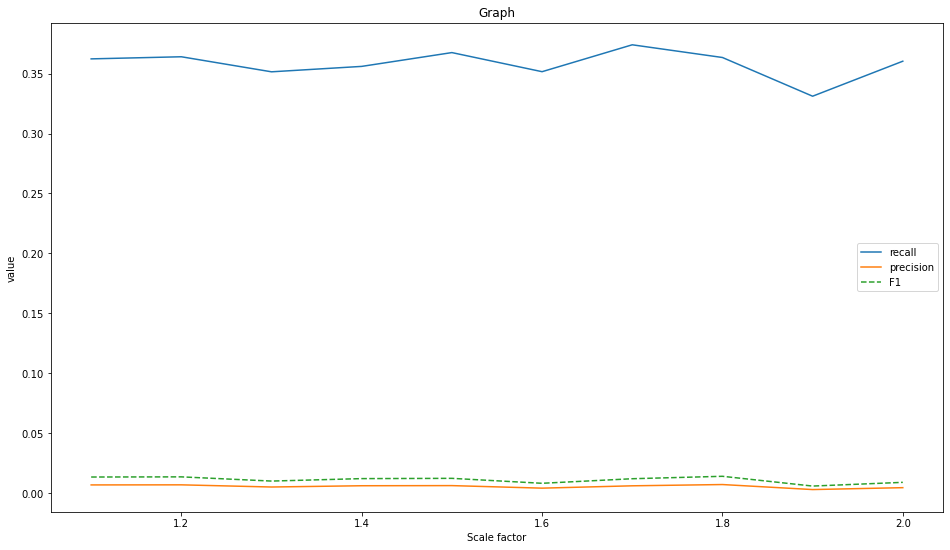

In [242]:
plotMetrics('squareWindows.csv')

To compare the results between the rectangular and square windows we created a comparison function. The first two params are the files with the results the 3rd is the metric by which we want to compare. By default it is F1

In [253]:
def compareSlidingWindows(file1, file2, comparisonBy='F1'):
    scale = []
    val1 = []
    metric = 3
    if comparisonBy == 'recall':
        metric = 1
    if comparisonBy == 'precision':
        metric = 2

    with open(file1, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = csv.reader(read_obj)
        # Iterate over each row in the csv using reader object
        i = 1
        for row in csv_reader:
            if i == 1:
                # so we do not include the headers
                i = 2
                continue
                # row variable is a list that represents a row in csv
            scale.append(float(row[0]))
            val1.append(float(row[metric])) 


    val2 = []
    with open(file2, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = csv.reader(read_obj)
        # Iterate over each row in the csv using reader object
        i = 1
        for row in csv_reader:
            if i == 1:
                # so we do not include the headers
                i = 2
                continue
                # row variable is a list that represents a row in csv
            val2.append(float(row[metric])) 


    plt.plot(scale, val1, label = file1)   
    plt.plot(scale, val2, label = file2) 

    
    plt.xlabel('Scale factor') 
    plt.ylabel('value') 
    plt.title('Comparison by ' + comparisonBy)  
    plt.legend() 
    


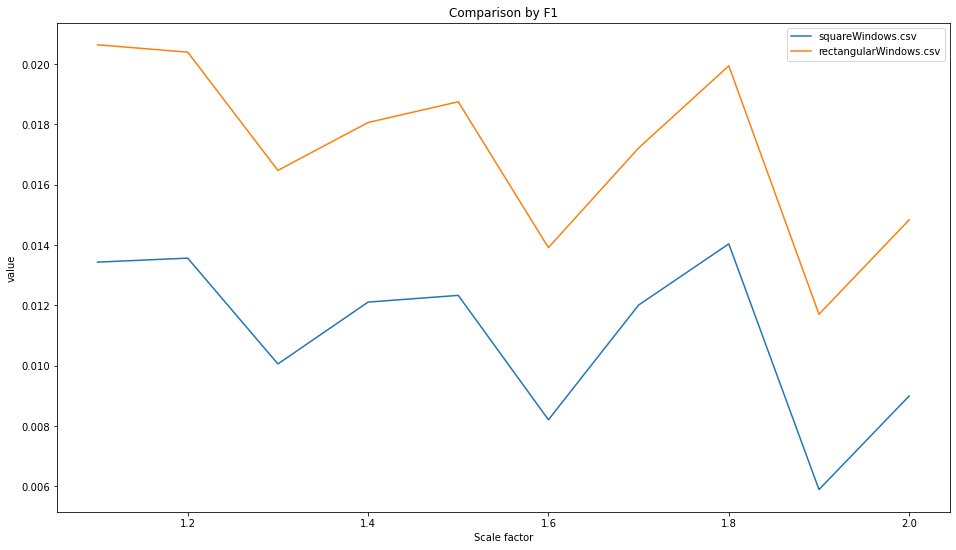

In [245]:
compareSlidingWindows('squareWindows.csv', 'rectangularWindows.csv')

In [246]:
compareSlidingWindows('squareWindows.csv', 'rectangularWindows.csv', 'recall')

In [247]:
compareSlidingWindows('squareWindows.csv', 'rectangularWindows.csv', 'precision')

With the comparison we can clearly see that the sliding widnow algorithm performs better when we use rectangular windows

## Sliding Window on A Pyramid

A similar approach will be used for a pyramid, however, we will extract all windows from all levels of the pyramid

In [277]:
def slidingWindowPyramid(image, imageWindow, scalingFactor=1.2, windowShape='square'):
    # to time the alogorithm
    start = time.perf_counter()
    img = cv2.imread(image.path, 0)

    pyramid = tuple(transform.pyramid_gaussian(
        img, downscale=2, sigma=2, multichannel=False))
    # extract all windows so they could be passed to the MLP at once
    windows = []
    # the positions of the sliding windows are also kept so once we have all predictions
    # we can compute IOU for all of them
    IOUarray = []
    maxIOU = 0

    level = 0
    for levelImg in pyramid:

        # starting size
        size = 16
        scale = scalingFactor

        imgH = levelImg.shape[0]
        imgW = levelImg.shape[1]

        while int(size) <= 33:
            step = int(size/4)
            winH = 0
            if windowShape == 'rectangle':

                winH = int(size / 3 * 4)
            else:
                winH = int(size)

            winW = int(size)
            for y in range(0, imgH - winH, step):
                for x in range(0, imgW - winW, step):
                    # extract subwindow
                    window = levelImg[y: y + winH, x: x + winW]
                    window = cv2.resize(
                        window, (imageWindow[1], imageWindow[0]), interpolation=cv2.INTER_LANCZOS4)

                    window = np.reshape(window, (imageWindow))
                    windows.append(window)
                    # instead extracting the window size and position we will directly compute and store
                    #  IOU for each window as at later state we would have to know the level in the pyramid
                    IOU = 0
                    for face in image.faceBoxes:
                        tempIOU = face.calculatePyramidIOU(
                            y,  y + winH, x, x + winW, level)
                        if tempIOU > IOU:
                            IOU = tempIOU
                        if tempIOU > maxIOU:
                            maxIOU = tempIOU
                    IOUarray .append(IOU)

            size = size * scale
        level += 1

    windows = np.asfarray(windows)
    predictions = model.predict(windows, steps=1)
    predictions = np.argmax(predictions, axis=1)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(predictions)):

        pred = predictions[i]
        IOU = IOUarray[i]
        if pred == 1 and IOU >= 0.5:
            TP += 1
        elif pred == 1 and IOU < 0.5:
            FP += 1
        elif pred == 0 and IOU >= 0.5:
            FN += 1
        elif pred == 0 and IOU < 0.5:
            TN += 1

    end = time.perf_counter()
    print("Time to execute in pyramid {}".format(end - start))
    # print("TP {}, FP {}, TN {}, FN {}".format(TP, FP, TN, FN))
    # precision = (TP) / (TP + FP)
    # if TP > 0 or FN > 0:
    #     recall = (TP) / (TP + FN)
    #     F1 = 2 * ((precision * recall) / (precision + recall))
    #     print("recall: {}".format(recall))
    #     print("F1 {}".format(F1))
    # print("accuracy: {}".format((TP + TN) / (TP + FP + TN + FN)))
    # print("precision: {}".format(precision))
    return TP, FP, FN, TN

In [275]:
slidingWindowPyramid(images[0], imageWindow, 1.2, 'rectangular')

Time to execute all in one 0.8058721029956359


(29, 32097, 6, 15361)

In [58]:
def testSlidingWindowPyramid(imageWindow, scale):    
    testImages = getFDDBImages(['10'])
    print(len(testImages))

    TP = 0
    FP = 0
    FN = 0
    TN = 0
    i =0
    for image in (testImages):
        print(i)
        i += 1
        result = slidingWindowPyramid(image, imageWindow, scale)
        TP += result[0]
        FP += result[1]
        FN += result[2]
        TN += result[3]
        # print(result)

    precision = (TP) / (TP + FP)
    recall = 0
    F1 = 0
    if TP > 0 or FN > 0:
        recall = (TP) / (TP + FN)
        F1 = 2 * ((precision * recall) / (precision + recall))
        print("recall: {}".format(recall))
        print("F1 {}".format(F1))
    print("accuracy: {}".format((TP + TN) / (TP + FP + TN + FN)))
    print("precision: {}".format(precision))
    return recall, precision, F1

In [59]:
# Create a file to save results of the model
with open('slidWindResSqrFullPyr.csv', mode='w') as csv_file:
       fieldnames = ['Scale', 'Recall', 'Precision', 'F1']
       writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
       writer.writeheader()



def saveResults(scale, rec, prec, f1):
  with open('slidWindResSqrFullPyr.csv', mode='a') as csv_file:
    fieldnames = ['Scale', 'Recall', 'Precision', 'F1']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writerow({'Scale':scale, 'Recall':rec, 'Precision':prec, 'F1':f1})

In [60]:
scales = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
for scale in scales:
    results = testSlidingWindowPyramid(imageWindow, scale)
    saveResults(scale, results[0], results[1], results[2])

563
141
Time to execute all in one 0.6551384670019615
142
Time to execute all in one 0.6474091439995391
143
Time to execute all in one 0.47609777999969083
144
Time to execute all in one 0.5348360139978467
145
Time to execute all in one 0.6689898779986834
146
Time to execute all in one 0.4358236219995888
147
Time to execute all in one 0.46426752700062934
148
Time to execute all in one 0.5594926869998744
149
Time to execute all in one 0.6444646639974962
150
Time to execute all in one 0.7291107310011284
151
Time to execute all in one 0.504165534999629
152
Time to execute all in one 0.5632956080007716
153
Time to execute all in one 0.5292060440006026
154
Time to execute all in one 0.46941352000067127
155
Time to execute all in one 0.536178774000291
156
Time to execute all in one 0.4511590399997658
157
Time to execute all in one 0.6980606560027809
158
Time to execute all in one 0.515521010998782
159
Time to execute all in one 0.4550405670015607
160
Time to execute all in one 1.0049910420020

In [248]:
plotMetrics('squareWindowsPyramid.csv')

In [249]:
plotMetrics('rectangularWindowsPyramid.csv')

In [250]:
compareSlidingWindows('squareWindowsPyramid.csv', 'rectangularWindowsPyramid.csv')

Yet again we see that the rectangular windows perform better than the square ones. Lets also compare F1 of the initia approch versus pyramid approach


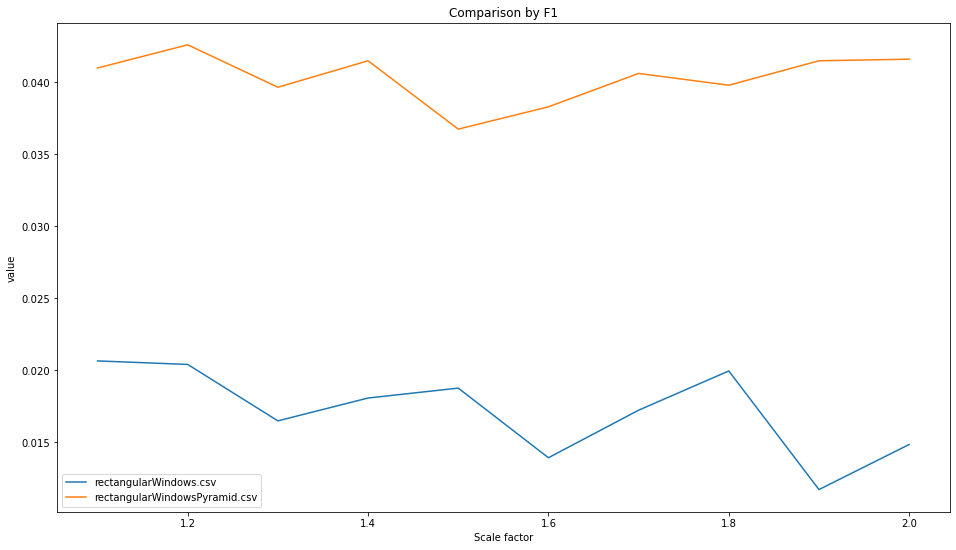

In [252]:
compareSlidingWindows('rectangularWindows.csv', 'rectangularWindowsPyramid.csv')

We can see that the overall metric F1 is much better for the algorithm that uses a pyramidm.
When it comes to time it is clear that the rectangular windows take more time as more rectangles need to be created to cover the whole image. We will only test the difference between the approach with an original image and pyramids as well as at different scales.


In [282]:
imageNumber = 100 # you can select a different image and measure the 2 algorithms
slidingWindow(images[imageNumber], imageWindow, 1.2, 'rectangular')
slidingWindowPyramid(images[imageNumber], imageWindow, 1.2, 'rectangular')
    
    


Time to execute in image  0.9119150890037417
Time to execute in pyramid 0.6259962820040528


(19, 33046, 6, 6368)

# Scale invariance in pyramid

In [232]:
def getPyramid(image, scale=2, minSize=(30, 30), sigma = 1):
    image = cv2.GaussianBlur(image,(7,7),sigma)
    yield image
    # keep looping over the pyramid
    while True:
        image = np.zeros((image.shape[0],image.shape[1],3),np.uint8)
        x=int(image.shape[0]/2)
        y=int(image.shape[1]/2)
        image[x,y] = (255,255,255)
#        image = cv2.GaussianBlur(image,(7,7),sigma)

        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = cv2.GaussianBlur(image,(7,7),sigma)
#        sigma = sigma*1.414213562
        image = cv2.GaussianBlur(image,(9,9),sigma*1.414213562)
#        sigma = sigma*1.414213562
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

(512, 512, 3)


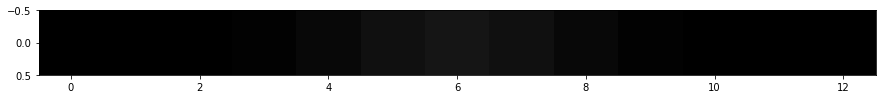

0
[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 2  2  2]
  [ 8  8  8]
  [16 16 16]
  [21 21 21]
  [16 16 16]
  [ 8  8  8]
  [ 2  2  2]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]
(256, 256, 3)


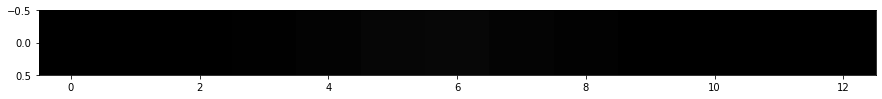

1
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  [1 1 1]
  [3 3 3]
  [6 6 6]
  [7 7 7]
  [4 4 4]
  [2 2 2]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(128, 128, 3)


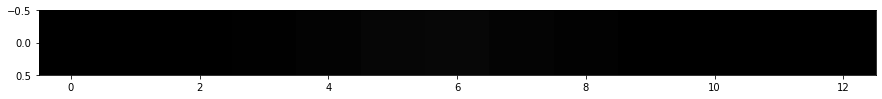

2
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  [1 1 1]
  [3 3 3]
  [6 6 6]
  [7 7 7]
  [4 4 4]
  [2 2 2]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(64, 64, 3)


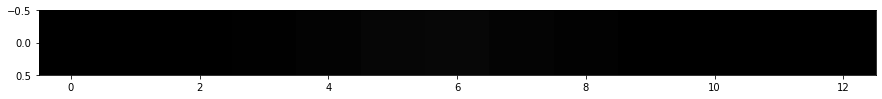

3
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  [1 1 1]
  [3 3 3]
  [6 6 6]
  [7 7 7]
  [4 4 4]
  [2 2 2]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(32, 32, 3)


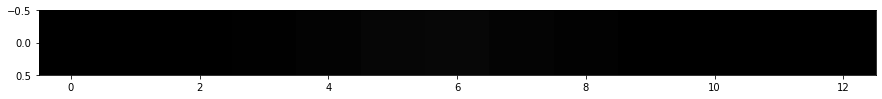

4
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  [1 1 1]
  [3 3 3]
  [6 6 6]
  [7 7 7]
  [4 4 4]
  [2 2 2]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [233]:
image = np.zeros((512,512,3),np.uint8)
image[256,256] = (255,255,255)

for (i, resized) in enumerate(pyramid(image, scale=2, sigma=1.414213562)):
#for (i, resized) in enumerate(pyramid_gaussian(image, downscale=2, sigma=1.414213562)):
#    if resized.shape[0] < 30 or resized.shape[1] < 30:
 #       break
    print(resized.shape)    
    image_row, image_col, channels = resized.shape
    fig=plt.figure(figsize=(15, 15))
    fig.add_subplot(1, 1, 1)
    resized1 = resized
    col1= int((image_col-12)/2)
    col2 = col1+13
    row = int(image_row/2)
    resized1 = resized1[row, col1:col2]
    resized1 = np.expand_dims(resized1,0)
    plt.imshow(resized1)
    plt.show()
    print(i)
    print(resized1)